# Long Short-Term Memory (LSTM) Analysis

- **Date Started:** May 9th, 2024
- **Author:** Ephraim Sun

## General Overview

Price prediction models are essential for investors and traders seeking to forecast future cryptocurrency prices. One method to do so is Long Short-Term Memory (LSTM).

LSTM is a deep learning, sequential neural network that allows information to persist (1). They are a special type of Recurrent Neural Networks, where it uses previous information to process for the current input. However, RNNs cannot remember long-term dependencies due to vanishing gradient, so LSTM solves this problem.

LSTM utilizes feedback corporation, allowing it to process entire sequences of data, not just individual points. 


## Imports and Setup


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, Input
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

## Data Fetching

We decided to retrieve the top 10 best cryptocurrencies based on market cap as of 05/11/2024. We have excluded stablecoins like Tether (USDT) and USDC. Therefore, we have the following coins in order of market capitalization (excluding stablecoins): 
1) Bitcoin (BTC)
2) Ethereum (ETH)
3) Solana (SOL)
4) Binance Coin (BNB)
5) XRP (XRP)
6) Toncoin (TON)
7) Dogecoin (DOGE)
8) Cardano (ADA)
9) Shiba Inu (SHIB)
10) Avalanche (AVAX)

From the above list, we notice that we have the two main cryptocurrencies Bitcoin and Ethereum, with Bitcoin around $1.2 trillion in value (according to CoinMarketCap) and Ethereum hovering around $3.5 billion, about 3x less the value compared to Bitcoin. In addition, we have 

In [ ]:
# Define the list of top 10 cryptocurrencies
top_10_cryptos = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'BNB-USD', 'XRP-USD', 'TON-USD', 'DOGE-USD', 'ADA-USD', 'SHIB-USD', 'AVAX-USD']

# Define the start and end dates
end_date = '2024-01-01'

data_filepath = './data'

# Fetch historical data for each cryptocurrency
for crypto_symbol in top_10_cryptos:
    # Fetch historical data using yfinance
    crypto_data = yf.download(crypto_symbol, end=end_date)
    
    # Save data to a CSV file
    file_name = os.path.join(data_filepath, f"{crypto_symbol}_data.csv")
    crypto_data.to_csv(file_name)


# Now each cryptocurrency's data is saved to a separate CSV file

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Bitcoin


In [4]:
csv_path = './data/BTC-USD_data.csv'
df_bitcoin = pd.read_csv(csv_path, parse_dates=['Date'])

In [5]:
df_bitcoin = df_bitcoin.sort_values('Date')

In [6]:
df_bitcoin.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
df_bitcoin.shape

(3393, 7)

Text(0, 0.5, 'Close Price (USD)')

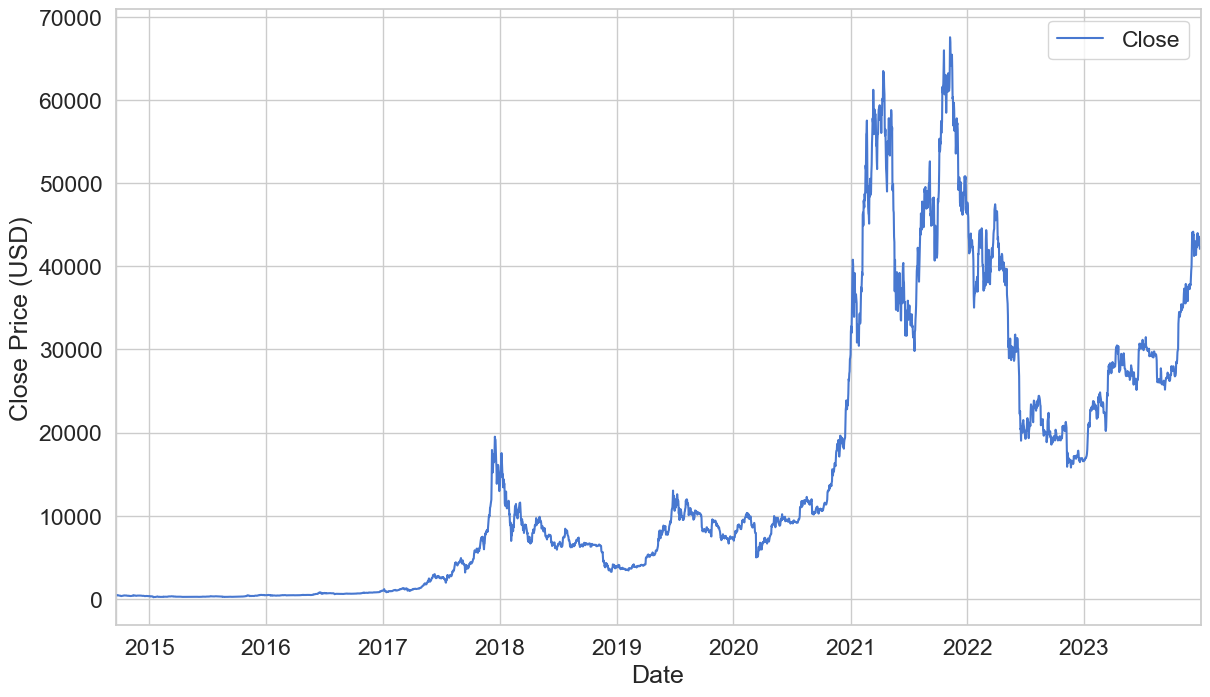

In [8]:
ax = df_bitcoin.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

## Normalization

In [9]:
scaler = MinMaxScaler()

close_price = df_bitcoin.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [10]:
scaled_close.shape

(3393, 1)

In [11]:
np.isnan(scaled_close).any()

False

In [12]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [13]:
scaled_close = scaled_close.reshape(-1, 1)

In [14]:
np.isnan(scaled_close).any()

False

## Preprocessing

In [15]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [16]:
X_train.shape

(3128, 99, 1)

In [17]:
X_test.shape

(165, 99, 1)

## Model

In [18]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

# Define input shape
input_shape = (WINDOW_SIZE, X_train.shape[-1])

# Define the input layer
inputs = Input(shape=input_shape)

model = keras.Sequential()

# Add the input layer to the model
model.add(inputs)

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))


## Training

In [19]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [20]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 461ms/step - loss: 0.0030 - val_loss: 0.0090
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 491ms/step - loss: 0.0060 - val_loss: 0.0017
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 574ms/step - loss: 0.0102 - val_loss: 0.0019
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 599ms/step - loss: 0.0089 - val_loss: 0.0013
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 598ms/step - loss: 0.0099 - val_loss: 0.0085
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 599ms/step - loss: 0.0077 - val_loss: 0.0278
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 601ms/step - loss: 0.0018 - val_loss: 0.0184
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 609ms/step - loss: 7.0384e-04 - val_loss: 8.7339e-04
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 620ms/step - loss: 0.0016 - val_loss: 2.8450e-04
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 587ms/step - loss: 7.0303e-04 - val_loss: 4.6427e-04
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 598ms/step - loss: 2.1252e-04 - val_loss: 9.7788e-04
Epoch 12/50
4

In [22]:
model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.6286e-04


0.0002234569110441953

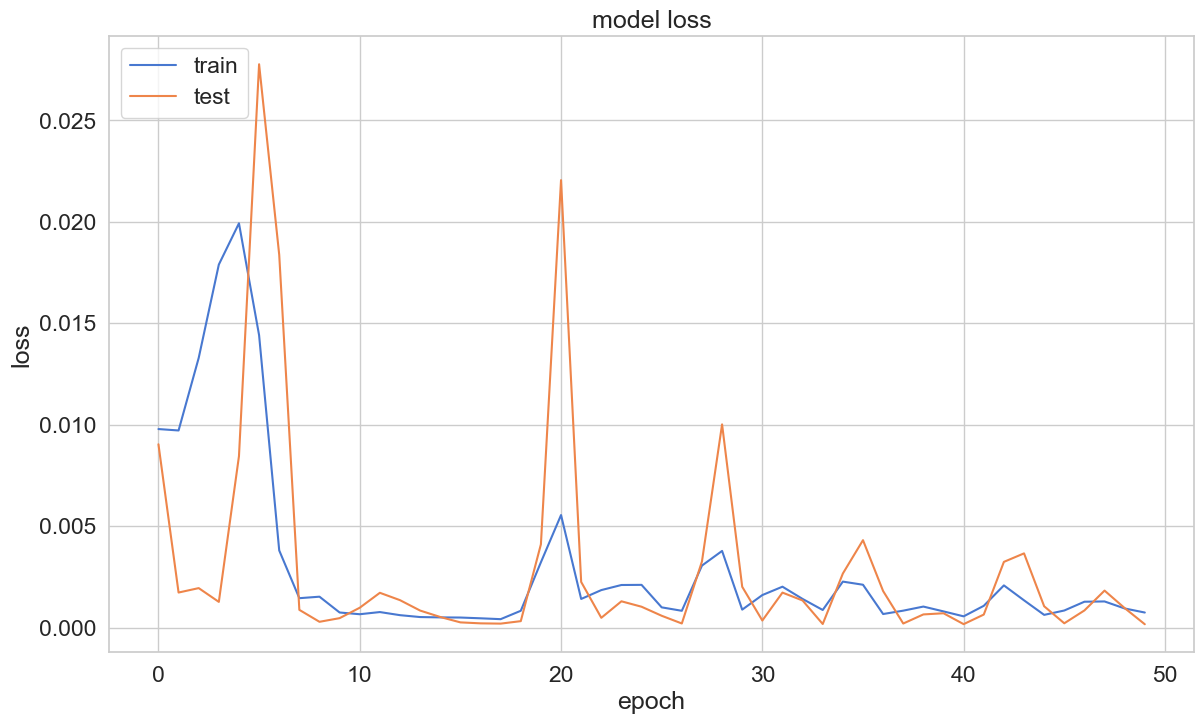

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


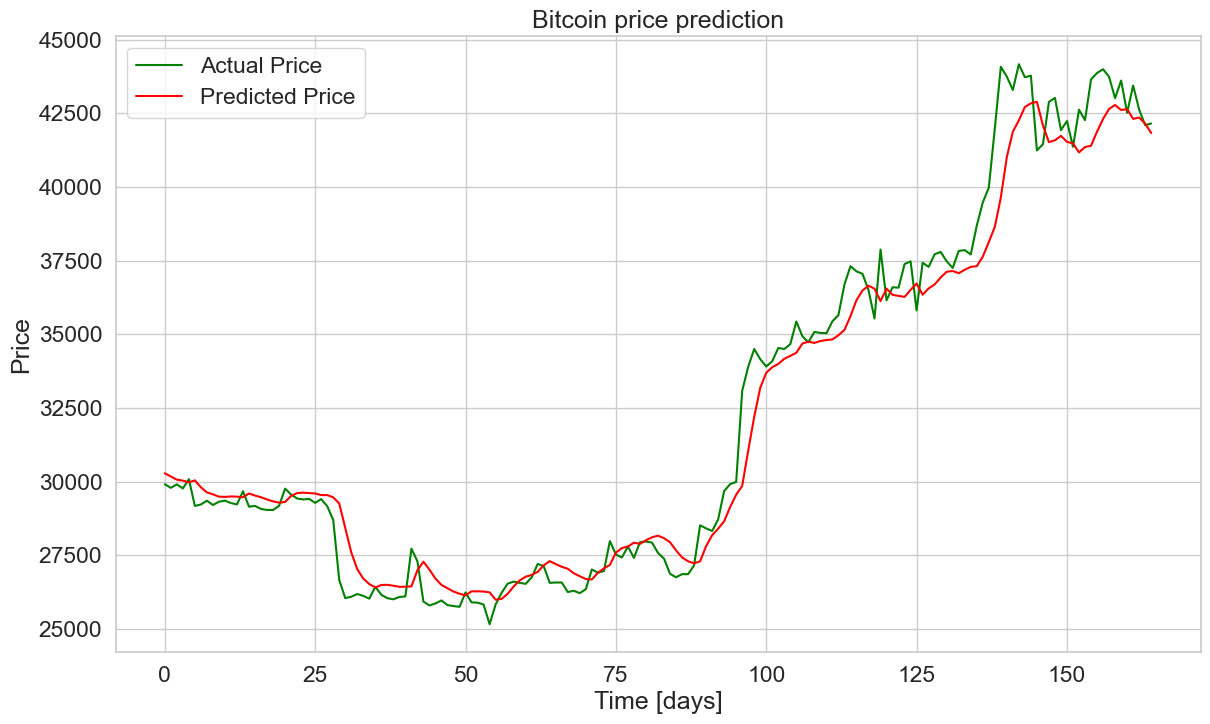

In [24]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

## Conclusion

## References

- 1. https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/
